[View in Colaboratory](https://colab.research.google.com/github/shimo8810/machine_intelligence/blob/master/chainer_test.ipynb)

In [1]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0   2866      0 --:--:-- --:--:-- --:--:--  2860
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-npp-dev-9-2
  cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
The following NEW packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-libraries-dev-9-2
  cuda-npp-dev-9-2 cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
0 upgraded, 9 newly installed, 0 to remove and 12 not upgraded.
Need to get 332 MB of archives.
After this operation, 972 MB of additional disk space will be used.
Get:1 https://develo

In [0]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.datasets import mnist

In [0]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

In [0]:
train, test = mnist.get_mnist()

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

In [0]:
class MLP(Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

model = MLP()

In [0]:
max_epoch = 10

model = L.Classifier(model)

gpu_id = 0  # Set to -1 if you use CPU
if gpu_id >= 0:
    model.to_gpu(gpu_id)  # If you use CPU, comment out this line

# selection of your optimizing method
optimizer = optimizers.MomentumSGD()

# Give the optimizer a reference to the model
optimizer.setup(model)

# Get an updater that uses the Iterator and Optimizer
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

# Setup a Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

In [0]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

In [32]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.560393    0.841934       0.265238              0.924743                  3.17278       
2           0.233205    0.931953       0.204295              0.938093                  6.80096       
3           0.179304    0.947578       0.159274              0.951938                  10.4958       
4           0.144133    0.9583         0.131942              0.959256                  14.2195       
5           0.121158    0.964636       0.112296              0.966179                  17.893        
6           0.103923    0.969316       0.105864              0.966673                  21.679        
7           0.0915343   0.973248       0.105136              0.967761                  25.3489       
8           0.0810351   0.976412       0.0907839             0.972013                  29.0477       
9           0.0704687   0.979594       0.086905              0.9732                 

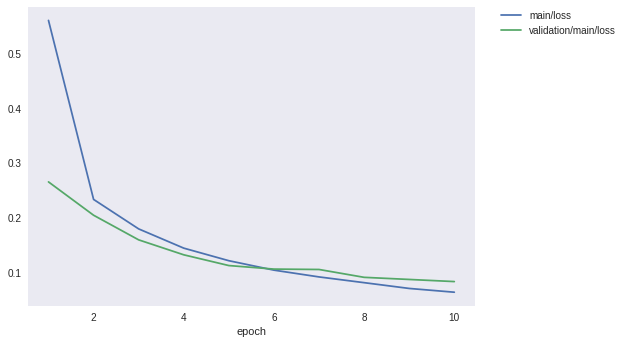

In [33]:
from IPython.display import Image
Image('mnist_result/loss.png')

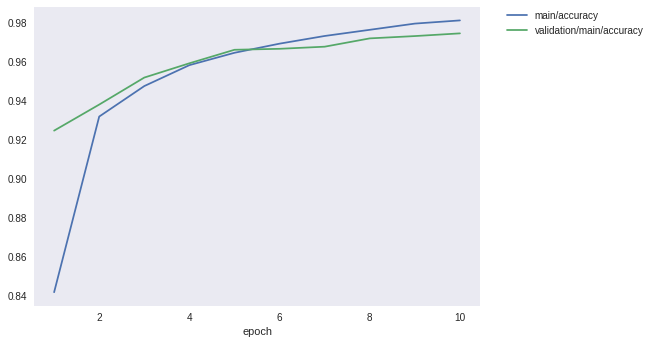

In [34]:
Image('mnist_result/accuracy.png')